# 铁路客流量预测

# 1 数据预处理

## 1.1 数据合并

In [1]:
import numpy as np
import pandas as pd
import os
import re
from itertools import chain

#### filename：每月的流量数据
#### datalist：将每个月每天所有流量数据汇总
#### date：每月数据总共涉及多少天

In [2]:
path = "D:/DataMiningProject/Project-02/data" #数据目录
filename = os.listdir(path)                   #文件夹下所有文件名称
n_filename = len(filename)                    #文件夹下文件总数量
datalist = []
date = []

for i in range(n_filename):
    name = "D:/DataMiningProject/Project-02/data/" + filename[i]  #访问总文件夹下的月份子文件夹
    datalist.append(["D:/DataMiningProject/Project-02/data/" + filename[i] + '/' + j for j in os.listdir(name)]) 
    #添加每个月份子文件夹下的日流量数据
    date.append(len(datalist[i]))  #统计每个月总共涉及多少天数的数据
filedata = list(chain.from_iterable(datalist)) #转换为一维列表
n_file = sum(date)
pd.DataFrame(filedata)

,0
0,D:/DataMiningProject/Project-02/data/201501/20...
1,D:/DataMiningProject/Project-02/data/201501/20...
2,D:/DataMiningProject/Project-02/data/201501/20...
3,D:/DataMiningProject/Project-02/data/201501/20...
4,D:/DataMiningProject/Project-02/data/201501/20...
...,...
433,D:/DataMiningProject/Project-02/data/201603/20...
434,D:/DataMiningProject/Project-02/data/201603/20...
435,D:/DataMiningProject/Project-02/data/201603/20...
436,D:/DataMiningProject/Project-02/data/201603/20...


#### 表格数据的含义
#### ~~上车站，第一个是始发站，其他都是中间站，对应列车离开车站的时间
#### ~~每一列最底部为上车总人数，中间依次对应之后的车站各自下车的人数
#### ~~每一行最右边为下车总人数，中间依次对应之前车站上车并在本站下车的人数

In [3]:
data = pd.read_excel(filedata[0])
row = data.shape[0]
Head_d = []
Line = []
for i in range(row):
    if '始发日期' in data.iloc[i,0]:
            Head_d.append(re.findall('[0-9\—]+',data.iloc[i,0]))
    if data.iloc[i,0] == '上车站':
            Line.append(re.findall('[A-Z]{2}[0-9]{2} ',data.iloc[i-1,0]))
Line = pd.DataFrame(Line) #以数据框的形式储存列车序号
Head_d = pd.DataFrame(Head_d)
Line['Head'] = 0 #在Line中新加入存放日期的列
for i in range(len(Line)):
    Line.iloc[i,1] = Head_d.iloc[0,0]
pd.DataFrame(Line)

,0,Head
0,PK11,20150101—20150101
1,GT01,20150101—20150101
2,PK17,20150101—20150101
3,PK18,20150101—20150101
4,PK02,20150101—20150101
...,...,...
57,PK03,20150101—20150101
58,PK07,20150101—20150101
59,PK01,20150101—20150101
60,PK06,20150101—20150101


## 所有csv文件汇总

In [4]:
for m in range(len(filedata)):
    data = pd.read_excel(filedata[m])
    row = data.shape[0]
    Head_d = []
    Line = []
    for i in range(row):
        if '始发日期' in data.iloc[i,0]:
                Head_d.append(re.findall('[0-9\—]+',data.iloc[i,0]))
        if data.iloc[i,0] == '上车站':
                Line.append(re.findall('[A-Z]{2}[0-9]{2} ',data.iloc[i-1,0]))
    Line = pd.DataFrame(Line) #以数据框的形式储存列车序号
    Head_d = pd.DataFrame(Head_d)
    Line['Head'] = 0 #在Line中新加入存放日期的列
    for i in range(len(Line)):
        Line.iloc[i,1] = Head_d.iloc[0,0]

#数据点位检索
    
    on_station = [i for i,x in enumerate(data.iloc[:,0]) if x == '上车站'] #上车站名称检索位置
    on_count = [i for i,x in enumerate(data.iloc[:,0]) if x == '上车人数合计'] #‘上车人数合计’数据检索位置
    Size = pd.DataFrame(np.zeros([len(on_station),2]),
                        columns = ['on_station','on_count'])
    Size['on_station'] = on_station
    Size['on_count'] = on_count
    Size['off_count'] = 0
    for h in range(len(Size.iloc[:,0])):
        Size.loc[h,'off_count'] = [i for i,x in enumerate(data.iloc[Size.iloc[h,0],:]) if x =='下车人数合计'] #下车人数数据检索位置

    goudu = pd.DataFrame(data.iloc[:,0])

#离车信息：离车站点、离车人数、离车时间点

    off_station=[]
    for i in range(len(Size.iloc[:,0])):
        off_station.append(goudu.iloc[Size.iloc[i,0]+2:Size.loc[i,'on_count'],0])

    sum_station = 0 #站点总数
    for i in range(len(off_station)):
        sum_station = sum_station + len(off_station[i])
        
    Out_off = pd.DataFrame(np.zeros([sum_station,3]),  
                          columns = ['off_station','off_man' ,'off_time'])

    h = 0
    for i in range(len(off_station)):
        Out_off.iloc[h:h + len(off_station[i]),0] = list(off_station[i])
        h = h + len(off_station[i])

    off_man = []
    for i in range(len(Size)):
        off_man.append(data.iloc[ Size.iloc[i,0]+2 : Size.loc[i,'on_count'] , Size.loc[i,'off_count']])
    
    h = 0
    for i in range(len(off_man)):
        Out_off.iloc[h:h + len(off_man[i]),1] = list(off_man[i])
        h = h + len(off_man[i])

    off_time = []#列车离开时间
    for i in range(len(Size)):
        off_time.append(data.iloc[Size.loc[i,'on_station']+2: Size.loc[i,'on_station']+2+len(off_station[i]), 1])
    
    h = 0
    for i in range(len(off_time)):
        Out_off.iloc[h:h+len(off_time[i]),2] = list(off_time[i])
        h = h + len(off_time[i])

#上车信息：上车站点、上车人数、上车时间点
    
    Come_on = pd.DataFrame(np.zeros([sum_station,3]),
                          columns = ['on_station' , 'on_man' , 'on_time'])
    on_station = []
    for i in range(len(Size)):
        on_station.append(data.iloc[Size.loc[i,'on_station'] , 2:Size.loc[i,'off_count']])

    h = 0
    for i in range(len(off_station)):
        Come_on.iloc[h:h+len(on_station[i]),0] = list(on_station[i])
        h = h + len(off_station[i])


    on_time = []
    for i in range(len(Size)):
        on_time.append(data.iloc[Size.loc[i,'on_station']+1 , 2:Size.loc[i,'off_count']])

    h = 0
    for i in range(len(on_time)):
        Come_on.iloc[h:h+len(on_time[i]),2] = list(on_time[i])
        h = h + len(off_time[i])

    on_man = []
    for i in range(len(Size)):
        on_man.append(data.iloc[Size.loc[i,'on_count'] , 2:Size.loc[i,'off_count']])

    h = 0
    for i in range(len(on_man)):
        Come_on.iloc[h:h+len(on_man[i]),1] = list(on_man[i])
        h = h + len(off_man[i])

    Station = pd.DataFrame(np.zeros([len(Out_off),7]),
                          columns = ['on_station','on_man','on_time','off_man','off_time','date','Train'])
    Station['on_station'] = list(Out_off.iloc[:,0])
    Station['off_man'] = list(Out_off['off_man'])
    Station['off_time'] = list(Out_off['off_time'])
    #这里注意iloc和loc的差别
    #iloc[1:3,:]只会读取1~2行
    #loc[1:3,:]会读取1~3行 所以下面的代码有-1操作
    k = 0
    for i in range(len(on_man)):
        Station.loc[k:k + len(on_man[i]) - 1,'on_man'] = list(on_man[i])
        Station.loc[k:k + len(on_time[i]) - 1,'on_time'] = list(on_time[i])
        Station.loc[k + len(on_man[i]):k + len(off_man[i]) - 1,'on_man'] = 0.1
        Station.loc[k + len(on_time[i]):k + len(off_man[i]) - 1,'on_time'] = 0.1
        Station.loc[k:k + len(off_time[i]) - 1,'date'] = Line.iloc[i,1]
        Station.loc[k:k + len(off_time[i]) - 1,'Train'] = Line.iloc[i,0]
        k = k + len(off_time[i])
    Station.to_csv("D:\\DataMiningProject\\Project-02\\full_information.csv", encoding = "utf_8",
                  index = False , header = False , mode = 'a+')

## 1.2 数据清洗

In [5]:
Train_Station = pd.read_csv("D:\\DataMiningProject\\Project-02\\full_information.csv",header = None, encoding ='utf_8')
Train_Station.columns = [ 'on_station','on_man','on_time','off_man','off_time','date','Train']
Train_Station.shape

(1584240, 7)

In [6]:
#进行清洗前先进行数据探索
Train_Station.describe()
#发现off_time和Train存在缺失值
#on_man和on_time存在异常值0.1

,on_station,on_man,on_time,off_man,off_time,date,Train
count,1584240,1584240,1584240,1584240,1538980,1584240,1581156
unique,1003,3057,893,2603,933,438,137
top,ST326,0.1,0.1,0.0,16:50,20150723—20150723,PK02
freq,112908,114316,114316,67172,8744,5824,62912


In [7]:
#查看缺失值
print(Train_Station.isnull().sum())
Train_Station.isnull().sum().sum() #缺失值总数

on_station        0
on_man            0
on_time           0
off_man           0
off_time      45260
date              0
Train          3084
dtype: int64


48344

#### 将异常值变为缺失值来处理

In [8]:
#将异常值设置为nan
Train_Station.loc[ Train_Station['on_man'] == '0.1' , 'on_man'] = np.nan
Train_Station.loc[ Train_Station['on_time'] == '0.1' , 'on_time'] = np.nan
Train_Station.describe()

,on_station,on_man,on_time,off_man,off_time,date,Train
count,1584240,1469924,1469924,1584240,1538980,1584240,1581156
unique,1003,3056,892,2603,933,438,137
top,ST326,11.0,14:38,0.0,16:50,20150723—20150723,PK02
freq,112908,10920,8752,67172,8744,5824,62912


In [9]:
#fillna将nan替换为0
Train_Station.fillna(0, inplace = True)

In [10]:
Train_Station.describe()

,on_station,on_man,on_time,off_man,off_time,date,Train
count,1584240,1584240,1584240,1584240,1584240,1584240,1584240
unique,1003,3057,893,2603,934,438,138
top,ST326,0,0,0.0,0,20150723—20150723,PK02
freq,112908,114316,114316,67172,45260,5824,62912


In [11]:
#查看数据类型
Train_Station.dtypes

on_station    object
on_man        object
on_time       object
off_man       object
off_time      object
date          object
Train         object
dtype: object

In [12]:
a1 = Train_Station['date'].str.split('—').str[0] #提取起始时间
a2 = Train_Station['date'].str.split('—').str[1] #提取终止时间
print(len(Train_Station['date']))
print((a1==a2).sum()) ##查看两时间相等的总数
Train_Station['date'] = a1 #将时间同一为第一个时间
Train_Station['date'] = pd.to_datetime(Train_Station['date']) #将时间的数据类型转化为时间戳

1584240
1584240


In [13]:
pd.DataFrame(Train_Station)

,on_station,on_man,on_time,off_man,off_time,date,Train
0,ST074,891.0,13:00,0.0,13:00,2015-01-01,PK11
1,ST219,69.0,13:41,161.0,13:39,2015-01-01,PK11
2,ST054,150.0,14:37,40.0,14:34,2015-01-01,PK11
3,ST036,72.0,15:22,25.0,15:19,2015-01-01,PK11
4,ST313,432.0,16:30,356.0,16:19,2015-01-01,PK11
...,...,...,...,...,...,...,...
1584235,ST233,8,23:39,41,23:34,2016-03-20,ZZ02
1584236,ST111-01,11,00:57,134,00:31,2016-03-20,ZZ02
1584237,ST326,1,02:05,77,02:03,2016-03-20,ZZ02
1584238,ST250,,03:04,78,03:00,2016-03-20,ZZ02


In [14]:
#部分数据为空格，全部替换为0
Train_Station['on_man'] = Train_Station['on_man'].astype('str').str.replace(' ','0').astype('float')
Train_Station['off_man'] = Train_Station['off_man'].astype('str').str.replace(' ','0').astype('float')
#数据保存
Train_Station.to_csv('D:/DataMiningProject/Project-02/Washed_information.csv', index = False ,encoding = "utf_8")
pd.DataFrame(Train_Station)

,on_station,on_man,on_time,off_man,off_time,date,Train
0,ST074,891.0,13:00,0.0,13:00,2015-01-01,PK11
1,ST219,69.0,13:41,161.0,13:39,2015-01-01,PK11
2,ST054,150.0,14:37,40.0,14:34,2015-01-01,PK11
3,ST036,72.0,15:22,25.0,15:19,2015-01-01,PK11
4,ST313,432.0,16:30,356.0,16:19,2015-01-01,PK11
...,...,...,...,...,...,...,...
1584235,ST233,8.0,23:39,41.0,23:34,2016-03-20,ZZ02
1584236,ST111-01,11.0,00:57,134.0,00:31,2016-03-20,ZZ02
1584237,ST326,1.0,02:05,77.0,02:03,2016-03-20,ZZ02
1584238,ST250,0.0,03:04,78.0,03:00,2016-03-20,ZZ02


In [15]:
Train_Station.isnull().sum().sum() 
#完成了数据清洗

0

## 1.3 数据可视化

### 1.3.1 不同站点客流量分布分析

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei' #设置中文正常显示
plt.rcParams['axes.unicode_minus'] = False #设置中文符号正常显示

In [17]:
on = pd.DataFrame(Train_Station['on_station']) #提取上车站信息
on = on.drop_duplicates() #去重
on['on_mean'] = 0
on['off_mean'] = 0
index = [i for i in range(len(on))]#修改左边的索引
on.index = index
on

,on_station,on_mean,off_mean
0,ST074,0,0
1,ST219,0,0
2,ST054,0,0
3,ST036,0,0
4,ST313,0,0
...,...,...,...
998,ST206,0,0
999,ST296,0,0
1000,ST016,0,0
1001,ST048,0,0


In [18]:
for i in range(len(on)):
    data = Train_Station[Train_Station.iloc[:,0] == on.iloc[i,0]]
    on.iloc[i,1] = sum(data.iloc[:,1])/(len(data))
    on.iloc[i,2] = sum(data.iloc[:,3])/(len(data))
on.to_csv('D:/DataMiningProject/Project-02/on_off_infromation.csv', encoding = "utf_8")
on

,on_station,on_mean,off_mean
0,ST074,1225.300459,0.000000
1,ST219,100.594037,109.727064
2,ST054,136.396789,66.511468
3,ST036,180.149083,43.433486
4,ST313,445.440367,222.321865
...,...,...,...
998,ST206,20.666667,10.666667
999,ST296,7.666667,10.000000
1000,ST016,11.733333,41.133333
1001,ST048,37.200000,69.133333


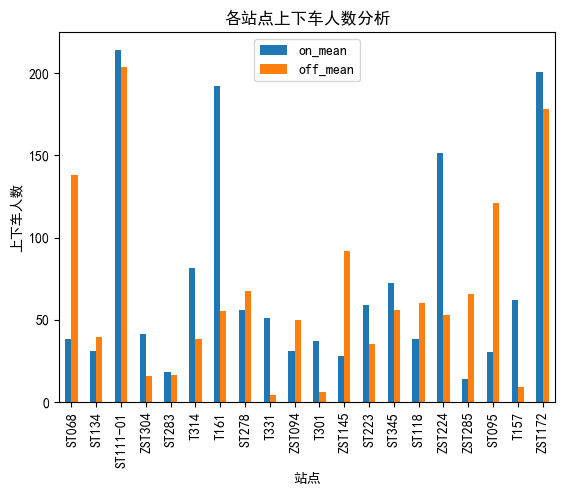

In [19]:
on_sample = on.sample(20, random_state = 44)
on_sample.index = on_sample['on_station']
on_sample.plot(kind = 'bar' , title = '各站点上下车人数分析')
plt.xlabel("站点")
plt.ylabel('上下车人数')
plt.show()

### 1.3.2 ST111-01站点 各时间段上下车人数分析

In [20]:
#提取ST111-1站点所有信息
Train_Station_01 = Train_Station[Train_Station.iloc[:,0] == 'ST111-01']
pd.DataFrame(Train_Station_01)

,on_station,on_man,on_time,off_man,off_time,date,Train
44,ST111-01,184.0,16:47,223.0,16:43,2015-01-01,GT01
145,ST111-01,104.0,20:06,105.0,20:04,2015-01-01,GT02
166,ST111-01,155.0,18:00,91.0,17:57,2015-01-01,GT03
175,ST111-01,183.0,12:41,103.0,12:38,2015-01-01,GT04
184,ST111-01,143.0,15:47,59.0,15:45,2015-01-01,GT05
...,...,...,...,...,...,...,...
1584108,ST111-01,15.0,00:58,140.0,01:51,2016-03-20,PK03
1584137,ST111-01,8.0,04:39,310.0,04:33,2016-03-20,PK07
1584156,ST111-01,155.0,18:39,149.0,18:36,2016-03-20,GT29
1584187,ST111-01,2.0,03:36,67.0,03:23,2016-03-20,PK01


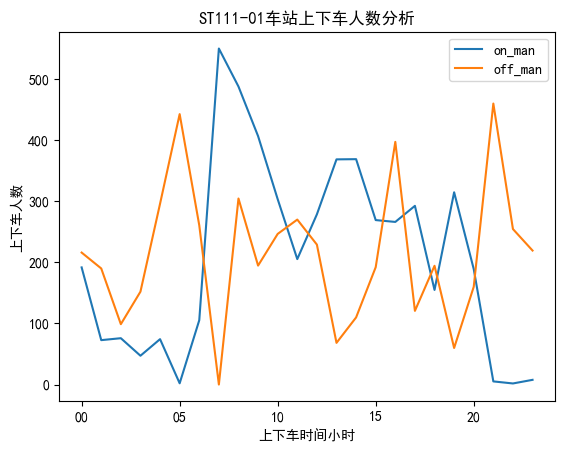

In [21]:
tmp = Train_Station_01.iloc[:,1:5]
#对上下车时间取小时部分
tmp['on_time'] = tmp['on_time'].str.split(':').str[0]
tmp['off_time'] = tmp['off_time'].str.split(':').str[0]
on_mean = tmp[['on_time','on_man']].groupby('on_time').agg({'on_man':'mean'})#按on_time分组，{'on_man':'mean'}表示对on_man取平均值
off_mean = tmp[['off_time','off_man']].groupby('off_time').agg({'off_man':'mean'})#按off_time分组，对off_man取平均值
on_and_off = on_mean.join(off_mean)
on_and_off.plot(kind = 'line' , title = 'ST111-01车站上下车人数分析')
plt.xlabel('上下车时间小时')
plt.ylabel('上下车人数')
plt.show()

### 1.3.3 ST111-01站点节假日客流量变化

In [22]:
#导出2015-2016两年的所有节假日
import holidays
holidays_2016 = pd.DataFrame(list(holidays.CN(years = 2016)))
holidays_2015 = pd.DataFrame(list(holidays.CN(years = 2015)))
holidays_2015_2016 = pd.DataFrame(np.zeros([len(holidays_2016)+len(holidays_2015),1]),
                                  columns = ['date'])
for i in range(len(holidays_2015)):
    holidays_2015_2016.loc[i,'date'] = holidays_2015.iloc[i,0]
for i in range(len(holidays_2015),len(holidays_2015_2016)):
    holidays_2015_2016.loc[i,'date'] = holidays_2016.iloc[i-len(holidays_2015),0]
holidays_2015_2016.to_csv('D:/DataMiningProject/Project-02/holidays_2015_2016.csv', index = False , encoding = "utf_8")

In [23]:
#所有节假日，日期以及当日上车人数
holidays = pd.read_csv('D:/DataMiningProject/Project-02/holidays_2015_2016.csv', encoding = "utf_8")
holidays['date'] = pd.to_datetime(holidays['date'])
#转化为时间戳数据类型
tmp = pd.merge(holidays , Train_Station_01 , on = 'date' , how =  'inner')  #以date为主键进行内合并
holiday_man = tmp.groupby('date').agg({'on_man':'sum'})
holiday_date_man = pd.merge(holidays , holiday_man ,  on = 'date' , how =  'inner')
pd.DataFrame(holiday_date_man)
holiday_date_man.to_csv('D:/DataMiningProject/Project-02/holiday_date_man.csv', index = False,encoding = "utf_8")

In [24]:
#所有天数，包括节假日和工作日，日期以及当日上车人数
total_date = pd.DataFrame(Train_Station_01.groupby('date')).iloc[:,0]
total_man = pd.DataFrame(Train_Station_01.groupby('date').agg({'on_man':'sum'}))
total_man.index = [i for i in range(len(total_date))]
total_date_man = pd.DataFrame(np.zeros([len(total_date),2]),
                             columns = ['date','on_man'])
total_date_man['date'] = total_date
total_date_man['on_man'] = total_man

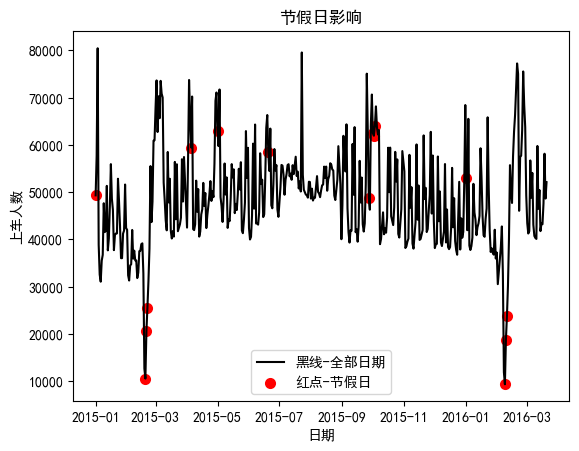

In [25]:
plt.plot(total_date_man['date'],total_date_man['on_man'].values , color = 'black')
plt.scatter(holiday_date_man['date'],holiday_date_man['on_man'].values, color = 'r', linewidth = 2)
plt.xlabel('日期')
plt.ylabel('上车人数')
plt.legend(['黑线-全部日期','红点-节假日'])
plt.title('节假日影响')
plt.show()